# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [5]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
interactions = pd.read_parquet("data/interactions.parquet")

In [4]:
tracks.head(5)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [5]:
tracks.shape

(1000000, 4)

In [6]:
tracks.dtypes

track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [7]:
catalog_names.head(5)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [ ]:
catalog_names.query("id == 3")

,id,type,name
0,3,album,Taller Children
812308,3,genre,rusrap


По одному id почему-то и альбом и жанр

In [9]:
catalog_names.query("id == 2490753")

,id,type,name
154612,2490753,album,Taller Children


In [10]:
catalog_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

В каталоге содержатся разные типы id, это и альбомы, и артисты, и жанры.

In [11]:
catalog_names.shape

(1812471, 3)

In [12]:
catalog_names.dtypes

id       int64
type    object
name    object
dtype: object

In [13]:
interactions.head(5)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [14]:
interactions.dtypes

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [15]:
interactions.shape

(222629898, 4)

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [16]:
# Количество пользователей, прослушавших трек
users_per_tracks = interactions.groupby('track_id', as_index=False).agg(
   users=("user_id", "nunique"),
   start_date=("started_at", "min"),
   end_date=("started_at", "max")
)
users_per_tracks.sort_values(by='users', ascending=False, inplace=True)
users_per_tracks['duration'] = (users_per_tracks['end_date'] - users_per_tracks['start_date']).dt.days

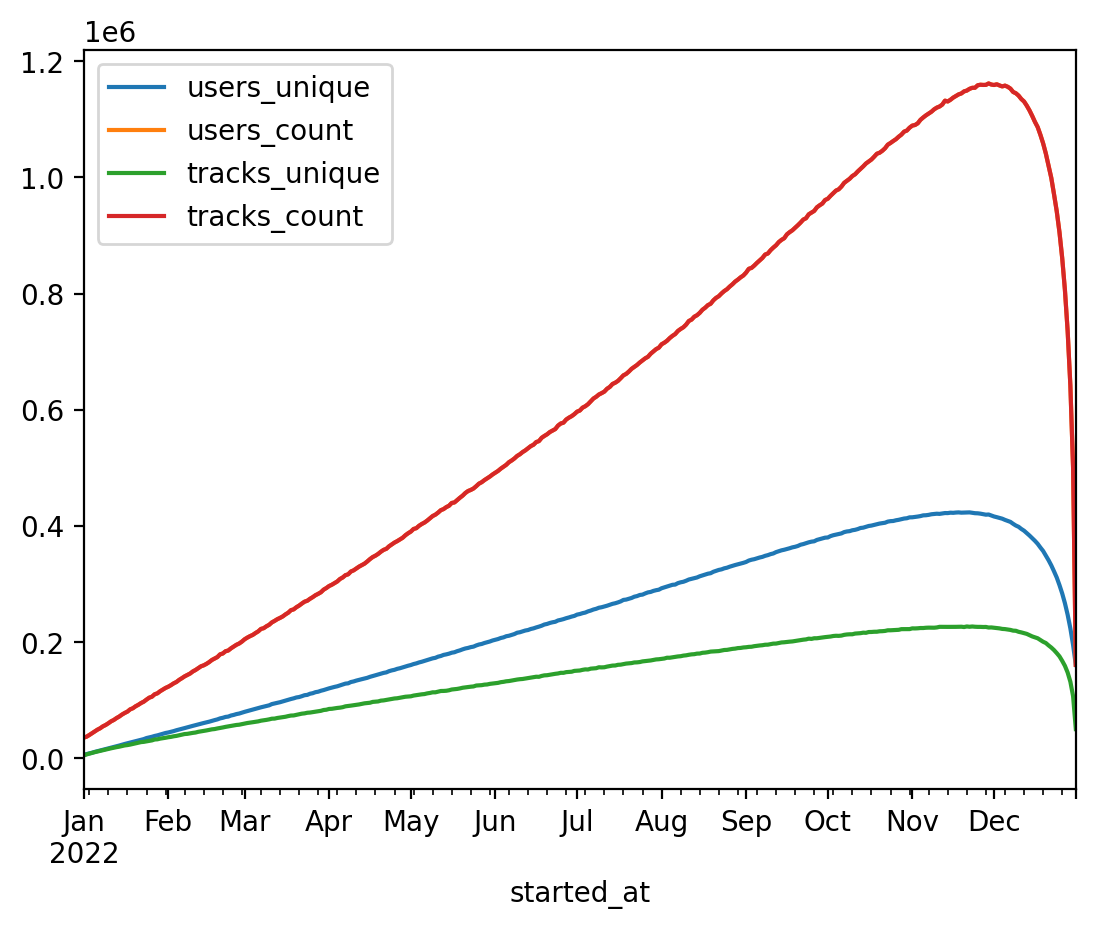

In [20]:
# Количество прослушанных пользователями треков в течение года
numbers_of_tracks = interactions.groupby('started_at').agg(
   users_unique=("user_id", "nunique"),
   users_count=("user_id", "count"),
   tracks_unique=("track_id", "nunique"),
   tracks_count=("track_id", "count")   
)
numbers_of_tracks.plot();

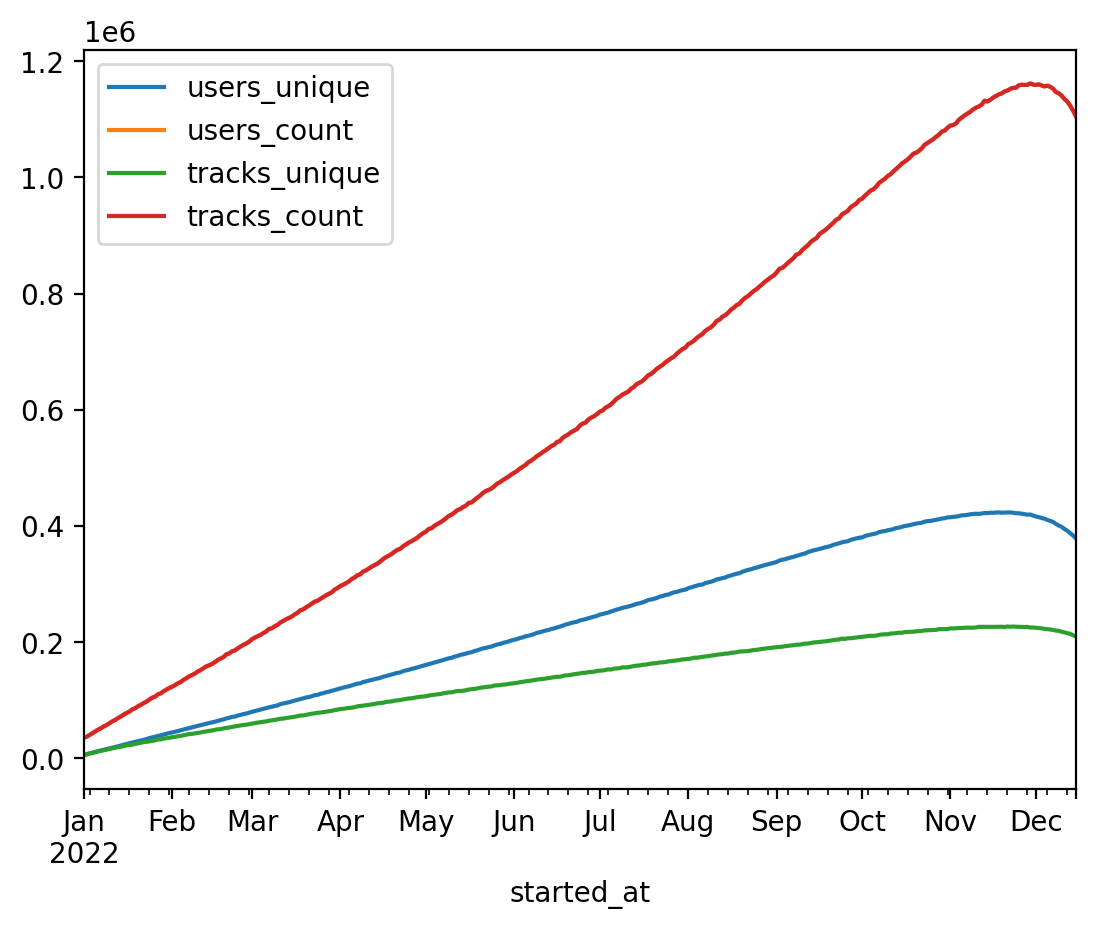

In [5]:
# Количество прослушанных пользователями треков на сокращенном промежутке времени
interactions.query("started_at < '2022-12-16'").groupby('started_at').agg(
   users_unique=("user_id", "nunique"),
   users_count=("user_id", "count"),
   tracks_unique=("track_id", "nunique"),
   tracks_count=("track_id", "count")   
).plot();

Проверим, есть ли в данных неизвестные треки

In [10]:
listened_tracks = list(interactions['track_id'].unique())

In [11]:
tracks[~tracks['track_id'].isin(listened_tracks)]

,track_id,albums,artists,genres


Нет треков, не попавших во взаимодействия с пользователями

In [23]:
tracks_per_users = interactions.groupby('user_id').agg(
   tracks_unique=("track_id", "nunique"),
   tracks_count=("track_id", "count"),
   start_date=("started_at", "min"),
   end_date=("started_at", "max")   
)
tracks_per_users['ltv'] = (tracks_per_users['end_date'] - tracks_per_users['start_date']).dt.days

Есть пользователи, которые послушали очень мало треков

In [74]:
tracks_per_users.sort_values(
    "tracks_unique", ascending=False
    ).query("ltv > 0")

,tracks_unique,tracks_count,start_date,end_date,ltv
user_id,,,,,
398979,16637,16637,2022-01-01,2022-12-31,364
1200889,15392,15392,2022-01-01,2022-12-31,364
590868,15136,15136,2022-01-01,2022-12-31,364
731216,13223,13223,2022-01-01,2022-12-31,364
339714,12768,12768,2022-01-01,2022-12-31,364
...,...,...,...,...,...
31743,2,2,2022-01-25,2022-12-23,332
1301289,2,2,2022-07-17,2022-09-19,64
856433,2,2,2022-04-27,2022-12-19,236


Проверим идентификаторы

In [11]:
interactions['track_id'].min(), interactions['track_id'].max()

(26, 101521819)

In [10]:
interactions['user_id'].min(), interactions['user_id'].max()

(0, 1374582)

In [24]:
interactions[interactions['user_id'] == 0]

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22
5,0,590803,6,2022-07-25
6,0,597196,7,2022-07-25
7,0,597199,8,2022-07-25
8,0,1750835,9,2022-07-30
9,0,1750843,10,2022-08-05


Последовательность прослушивания треков не разбита по датам

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Обрезать дату по декабрь  
Нет не прослушанных треков    

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [12]:
listened_tracks = interactions.groupby('started_at').agg(
   tracks_unique=("track_id", "nunique"),
   tracks_count=("track_id", "count")   
)

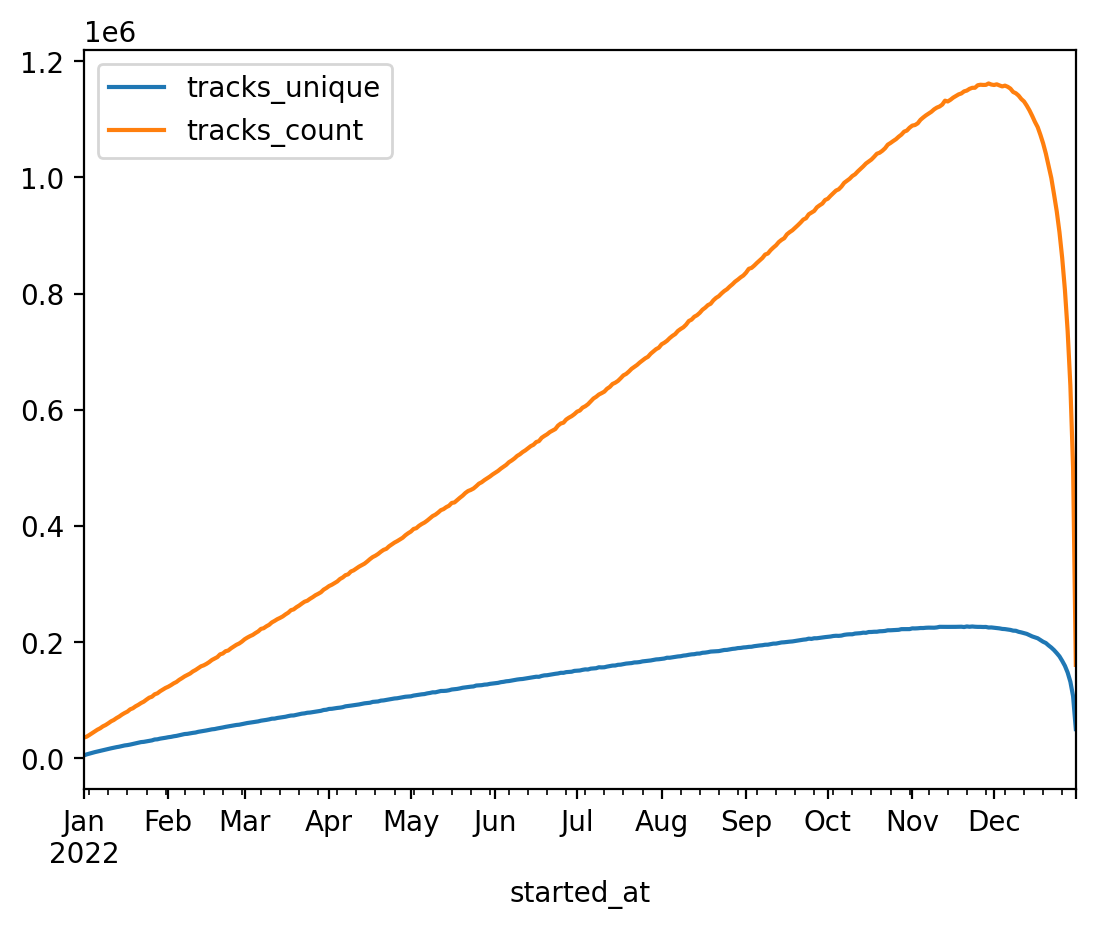

In [13]:
listened_tracks.plot();

Наиболее популярные треки

In [14]:
users_per_tracks = interactions.groupby('track_id', as_index=False).agg(
   users=("user_id", "nunique"),
   start_date=("started_at", "min"),
   end_date=("started_at", "max")
)

In [15]:
popular_tracks = pd.merge(
    users_per_tracks, 
    catalog_names.query("""type == 'track'"""), 
    left_on='track_id', 
    right_on='id',
    how='left'
).drop(['id', 'type'], axis=1).reset_index(drop=True)

In [16]:
assert False
popular_tracks.to_parquet('data/popular_tracks.parquet', index=False)

Наиболее популярные жанры

In [17]:
genres = pd.DataFrame(tracks['genres'].explode().value_counts()).reset_index()
genres = pd.merge(
    genres, 
    catalog_names.query("""type == 'genre'"""), 
    left_on='genres', 
    right_on='id',
    how='left'
).drop(['id', 'type'], axis=1)

In [18]:
assert False
genres.to_parquet('data/genres.parquet', index=False)

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [16]:
interactions['tracks_cnt'] = interactions.groupby('user_id')['track_id'].transform('nunique')
interactions['users_cnt'] = interactions.groupby('track_id')['user_id'].transform('nunique')
interactions.query("tracks_cnt >= 2", inplace=True) # фильтруем тех, кто редко что-то слушает
interactions.query("users_cnt > 0", inplace=True)

In [64]:
listened_tracks = list(interactions['track_id'].unique())
tracks = tracks[tracks['track_id'].isin(listened_tracks)]

Так как текущий объем данных работает просто невыносимо долго и ядро с ним не справляется даже когда импортирован только один датафрейм, возьмем стратифицированный семпл

### Обработка событий

In [10]:
# Возьмем только 10% данных для ускорения вычислений, стратифицируем по датам
interactions_sample = interactions.groupby(
    'started_at', group_keys=False
    ).apply(lambda x: x.sample(round(0.1*len(x))))

In [6]:
# interactions_sample = pd.read_parquet('data/events_sample.parquet').rename(columns={'item_id': 'track_id'})

In [11]:
interactions_sample.query("user_id == 1")

,user_id,track_id,track_seq,started_at
10,1,25973493,11,2022-06-25
12,1,31763491,13,2022-06-26
14,1,34685697,15,2022-07-03
22,1,41554596,23,2022-07-14
28,1,77549332,29,2022-07-22


In [12]:
track_seq_len = (interactions_sample.query("user_id == 1"))

In [13]:
interactions_sample.sort_values(by=['user_id', 'track_seq'], inplace=True)
# теперь нужно перенумеровать порядок прослушивания треков
interactions_sample['track_seq'] = interactions_sample.groupby(
    'user_id', as_index=False
    ).cumcount() + 1

In [14]:
interactions_sample.query("user_id == 1")

,user_id,track_id,track_seq,started_at
10,1,25973493,1,2022-06-25
12,1,31763491,2,2022-06-26
14,1,34685697,3,2022-07-03
22,1,41554596,4,2022-07-14
28,1,77549332,5,2022-07-22


In [15]:
# перенумеруем также пользователей
interactions_sample['user_id'] = interactions_sample.groupby('user_id').ngroup() + 1
interactions_sample['user_id'] = 1_000_000 + interactions_sample['user_id'] - 1

In [ ]:
interactions_sample.reset_index(drop=True, inplace=True)

In [21]:
interactions_sample.query("user_id == 1000000")

,user_id,track_id,track_seq,started_at
0,1000000,25973493,1,2022-06-25
1,1000000,31763491,2,2022-06-26
2,1000000,34685697,3,2022-07-03
3,1000000,41554596,4,2022-07-14
4,1000000,77549332,5,2022-07-22


In [18]:
interactions_sample.shape[0]/interactions.shape[0]

0.09999998293131321

In [19]:
interactions_sample.shape

(22262986, 4)

In [20]:
interactions_sample.head()

,user_id,track_id,track_seq,started_at
0,1000000,25973493,1,2022-06-25
1,1000000,31763491,2,2022-06-26
2,1000000,34685697,3,2022-07-03
3,1000000,41554596,4,2022-07-14
4,1000000,77549332,5,2022-07-22


In [22]:
interactions_sample['tracks_cnt'] = \
    interactions_sample.groupby('user_id')['track_id'].transform('nunique')
interactions_sample['users_cnt'] = \
    interactions_sample.groupby('track_id')['user_id'].transform('nunique')

# фильтруем тех, кто редко что-то слушает
interactions_sample.query("tracks_cnt >= 2", inplace=True)
# фильтруем непопулярные треки 
interactions_sample.query("users_cnt > 0", inplace=True)

### Обработка треков

In [2]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")

In [3]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [4]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [5]:
# обрежем количество для упрощения вычислений
tracks['genres'] = tracks.genres.apply(lambda x: x[:2])
tracks['artists'] = tracks.artists.apply(lambda x: x[:2])
tracks['albums'] = tracks.albums.apply(lambda x: x[:2])

Формируем датафрейм с перенумерованными жанрами исполнителей и словариками 

In [6]:
tracks[['genre_1', 'genre_2']] = tracks.genres.apply(pd.Series)
tracks[['artist_1', 'artist_2']] = tracks.artists.apply(pd.Series)
tracks[['album_1', 'album_2']] = tracks.albums.apply(pd.Series)

In [9]:
genres = pd.DataFrame(tracks['genres'].explode().value_counts()).reset_index()
genre_id_mapping = {genre: idx for idx, genre in enumerate(genres['genres'])}

artists = pd.DataFrame(tracks['artists'].explode().value_counts()).reset_index()
artist_id_mapping = {artist: idx for idx, artist in enumerate(artists['artists'])}

albums = pd.DataFrame(tracks['albums'].explode().value_counts()).reset_index()
album_id_mapping = {album: idx for idx, album in enumerate(albums['albums'])}

In [10]:
def get_dict_mapping(x, name_type, id_mapping):
    if x[f'{name_type}_1'] != 'None' and x[f'{name_type}_2'] != 'None':
        return { 
                id_mapping[x[f'{name_type}_1']]: x[f'{name_type}_name_1'], 
                id_mapping[x[f'{name_type}_2']]: x[f'{name_type}_name_2']
            }
    elif x[f'{name_type}_1'] != 'None':
        return { 
                id_mapping[x[f'{name_type}_1']]: x[f'{name_type}_name_1']
            }
    elif x[f'{name_type}_2'] != 'None':
        return { 
                id_mapping[x[f'{name_type}_2']]: x[f'{name_type}_name_2']
            }
    else:
        return {}

In [11]:
tracks_tmp = tracks.copy()
name_types = list(catalog_names['type'].value_counts().index)
print(name_types)

for name_type in name_types:
    if name_type == 'track':
        tracks_tmp = pd.merge(
            tracks_tmp,
            catalog_names.query(
                f"type == '{name_type}'"
                )[['id', 'name']].rename(
                    columns={'name': f'{name_type}_name'}
                    ),
            left_on=f'track_id',
            right_on='id'
        ).drop(['id'], axis=1)
    else:
        for num in ['1', '2']:
            tracks_tmp = pd.merge(
                tracks_tmp,
                catalog_names.query(
                    f"type == '{name_type}'"
                    )[['id', 'name']].rename(
                        columns={'name': f'{name_type}_name_{num}'}
                        ),
                left_on=f'{name_type}_{num}',
                right_on='id',
                how='left'
            ).drop(['id'], axis=1)

        if name_type == 'genre':
            id_mapping = genre_id_mapping.copy()
        elif name_type == 'artist':
            id_mapping = artist_id_mapping.copy()
        elif name_type == 'album':
            id_mapping = album_id_mapping.copy()

        tracks_tmp[f'{name_type}s'] = tracks_tmp.fillna('None').apply(
            lambda x: get_dict_mapping(x, name_type, id_mapping), axis=1
        ).astype(str)
        

['track', 'album', 'artist', 'genre']


In [12]:
tracks_tmp[['track_id', 'albums', 'artists', 'genres', 'track_name']].head(5)

,track_id,albums,artists,genres,track_name
0,26,"{158401: 'Taller Children', 158386: 'Taller Ch...",{66830: 'Elizabeth & the Catapult'},"{0: 'pop', 13: 'folk'}",Complimentary Me
1,38,"{158401: 'Taller Children', 158386: 'Taller Ch...",{66830: 'Elizabeth & the Catapult'},"{0: 'pop', 13: 'folk'}",Momma's Boy
2,135,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},Atticus
3,136,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},24 Hours
4,138,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},Don't Upset The Rhythm (Go Baby Go)


In [13]:
tracks_tmp[['track_id', 'albums', 'artists', 'genres', 'track_name']].dtypes

track_id       int64
albums        object
artists       object
genres        object
track_name    object
dtype: object

In [14]:
tracks_tmp.shape

(1000000, 17)

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [21]:
interactions.rename(columns={'track_id': 'item_id'}).to_parquet('data/events.parquet', index=False)

In [35]:
interactions_sample.rename(
    columns={'track_id': 'item_id'}
    ).to_parquet('data/events_sample.parquet', index=False)

In [15]:
tracks_tmp.rename(
    columns={'track_id': 'item_id'}
    ).to_parquet('data/items.parquet', index=False)

In [17]:
tracks_tmp[['track_id', 'albums', 'artists', 'genres', 'track_name']].rename(
    columns={'track_id': 'item_id'}
).to_parquet('data/items_sample.parquet', index=False)

In [4]:
import boto3
import os
 
def get_session_student():
    session = boto3.session.Session()
 
    return session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    )
 
s3 = get_session_student()
bucket_name = os.getenv("S3_BUCKET_NAME")
 
s3.upload_file("data/items.parquet", bucket_name, 'recsys/data/items.parquet')
s3.upload_file("data/events.parquet", bucket_name, 'recsys/data/events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid
import pickle

import scipy
import sklearn.preprocessing

In [3]:
events = pd.read_parquet('data/events_sample.parquet')
items = pd.read_parquet('data/items_sample.parquet')

In [4]:
events.query('user_id == 1000000')

,user_id,item_id,track_seq,started_at,tracks_cnt,users_cnt
0,1000000,25973493,1,2022-06-25,5,36
1,1000000,31763491,2,2022-06-26,5,489
2,1000000,34685697,3,2022-07-03,5,18
3,1000000,41554596,4,2022-07-14,5,131
4,1000000,77549332,5,2022-07-22,5,380


In [5]:
items.head()

,item_id,albums,artists,genres,track_name,item_id_enc
0,26,"{158401: 'Taller Children', 158386: 'Taller Ch...",{66830: 'Elizabeth & the Catapult'},"{0: 'pop', 13: 'folk'}",Complimentary Me,0
1,38,"{158401: 'Taller Children', 158386: 'Taller Ch...",{66830: 'Elizabeth & the Catapult'},"{0: 'pop', 13: 'folk'}",Momma's Boy,1
2,135,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},Atticus,2
3,136,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},24 Hours,3
4,138,"{39144: 'Wild Young Hearts', 39140: 'Wild Youn...",{16729: 'Noisettes'},{0: 'pop'},Don't Upset The Rhythm (Go Baby Go),4


In [5]:
users_per_tracks = events.groupby('item_id', as_index=False).agg(
   users=("user_id", "nunique")
)
users_per_tracks.sort_values(by='users', ascending=False, inplace=True)

popular_tracks = pd.merge(
    users_per_tracks, 
    items, 
    left_on='item_id', 
    right_on='item_id',
    how='left'
)
popular_tracks.to_parquet('data/popular_tracks.parquet', index=False)

In [6]:
popular_tracks

,item_id,users,albums,artists,genres,track_name
0,53404,11072,"{18077: 'Nevermind', 26411: 'Nirvana'}",{37: 'Nirvana'},"{10: 'alternative', 7: 'rock'}",Smells Like Teen Spirit
1,33311009,10489,"{25561: 'Shape Of Pop', 11011: ""NOW That's Wha...",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Believer
2,178529,9993,"{9745: 'Meteora', 9746: 'Meteora'}",{115: 'Linkin Park'},"{41: 'numetal', 4: 'metal'}",Numb
3,35505245,9813,"{204897: 'I Got Love', 204898: 'I Got Love'}","{1827: 'Miyagi & Эндшпиль', 154: 'Рем Дигга'}","{5: 'rusrap', 1: 'rap'}",I Got Love
4,65851540,8583,{369727: 'Юность'},{1013: 'Dabro'},"{0: 'pop', 9: 'ruspop'}",Юность
...,...,...,...,...,...,...
791449,101308853,1,{16745: 'Cowboy Tears'},{3172: 'Oliver Tree'},{15: 'indie'},Things We Used To Do
791450,101144891,1,{158452: 'Роза Дель Валье'},"{78921: 'Jagame', 78920: 'Mendiga'}","{6: 'foreignrap', 1: 'rap'}",Роза Дель Валье
791451,101152036,1,{158454: 'Shot Me Down'},{47682: 'Miyagi'},"{6: 'foreignrap', 1: 'rap'}",Shot Me Down
791452,101188615,1,{158442: 'Она моя'},{12431: 'Эрнест Геворгян'},{0: 'pop'},Она моя


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [7]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train)&set(users_test)

print(len(users_train), len(users_test), len(common_users))

1106263 387846 357376


In [6]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [7]:
assert False
events_train.to_parquet('data/events_train.parquet', index=False)
events_test.to_parquet('data/events_test.parquet', index=False)
items.to_parquet('data/items_sample.parquet', index=False)

In [ ]:
assert False
with open('user_encoder.pkl', 'wb') as file:
    pickle.dump(user_encoder, file)

with open('item_encoder.pkl', 'wb') as file:
    pickle.dump(item_encoder, file)

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing

In [21]:
events_train = pd.read_parquet('data/events_train.parquet')
events_test = pd.read_parquet('data/events_test.parquet')
items = pd.read_parquet('data/items.parquet')

In [10]:
popular_items = events_train.groupby('item_id', as_index=False).agg(
   items_unique=("user_id", "nunique")
).sort_values(by='items_unique', ascending=False)

In [11]:
top_k_pop_items = popular_items[:100]

In [12]:
top_k_pop_items = pd.merge(
    top_k_pop_items,
    items, 
    left_on="item_id",
    right_on="item_id",
    how="left",
)

In [13]:
with pd.option_context('display.max_rows', 5):
    display(top_k_pop_items[:5])

,item_id,items_unique,albums,artists,genres,track_name,item_id_enc
0,53404,10975,"{18077: 'Nevermind', 26411: 'Nirvana'}",{37: 'Nirvana'},"{10: 'alternative', 7: 'rock'}",Smells Like Teen Spirit,9098
1,33311009,9927,"{25561: 'Shape Of Pop', 11011: ""NOW That's Wha...",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Believer,483876
2,178529,9903,"{9745: 'Meteora', 9746: 'Meteora'}",{115: 'Linkin Park'},"{41: 'numetal', 4: 'metal'}",Numb,26665
3,35505245,9445,"{204897: 'I Got Love', 204898: 'I Got Love'}","{1827: 'Miyagi & Эндшпиль', 154: 'Рем Дигга'}","{5: 'rusrap', 1: 'rap'}",I Got Love,512157
4,795836,8249,"{35640: ""Ten Summoner's Tales"", 740: '25 Years'}",{109: 'Sting'},"{0: 'pop', 7: 'rock'}",Shape Of My Heart,90461


In [20]:
assert False
top_k_pop_items.to_parquet("data/top_k_pop_items.parquet", index=False)

In [12]:
top_k_pop_items.reset_index(inplace=True)
top_k_pop_items.rename(columns={'index': 'rank'}, inplace=True)
top_k_pop_items['rank'] = top_k_pop_items['rank'] + 1

Теперь получим персональные рекомендации для пользователей холодного стартав тестовых данных. 

In [15]:
cold_users = set(users_test)-set(users_train)
print(len(cold_users))

30470


In [16]:
cold_users_events_with_recs = pd.merge(
    events_test[events_test["user_id"].isin(cold_users)],
    top_k_pop_items, 
    left_on="item_id",
    right_on="item_id",
    how="left"
)

In [32]:
events_test['key'] = 1
top_k_pop_items['key'] = 1

In [40]:
users_events_with_top_recs = pd.merge(
    events_test[['user_id']],
    top_k_pop_items[['item_id', 'rank']][:10], 
    how='cross'
)

In [41]:
users_events_with_top_recs

,user_id,item_id,rank
0,1000006,53404,1
1,1000006,33311009,2
2,1000006,178529,3
3,1000006,35505245,4
4,1000006,795836,5
...,...,...,...
13695085,2287702,24692821,6
13695086,2287702,6705392,7
13695087,2287702,37384,8
13695088,2287702,45499814,9


In [43]:
assert False
users_events_with_top_recs.to_parquet("data/top_popular.parquet", index=False)

In [45]:
pd.read_parquet("ml_service/data/top_popular.parquet",
        columns=["user_id", "item_id", "rank"]).head(5)

,user_id,item_id,rank
0,1000006,53404,1
1,1000006,33311009,2
2,1000006,178529,3
3,1000006,35505245,4
4,1000006,795836,5


In [17]:
cold_users_events_with_recs.head(1)

,user_id,item_id,track_seq,started_at,tracks_cnt,users_cnt,user_id_enc,item_id_enc_x,items_unique,albums,artists,genres,track_name,item_id_enc_y
0,1000014,65851540,1,2022-12-20,3,8781,13,829320,7520.0,{369727: 'Юность'},{1013: 'Dabro'},"{0: 'pop', 9: 'ruspop'}",Юность,829320.0


In [18]:
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["items_unique"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx]

Покрытие холодного старта:

In [19]:
len(cold_users_events_with_recs[cold_user_items_no_avg_rating_idx])/len(cold_users_events_with_recs)

0.9460145328464461

In [20]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(
    hits=("items_unique", lambda x: (~x.isnull()).mean())
    )

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.81
Среднее покрытие пользователей: 0.30


# Жанры

Добавление жанров в пайплайн

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares

In [ ]:
items = pd.read_parquet('data/items.parquet')

In [9]:
items["genres"] = items["genres"].apply(eval)

In [13]:
def get_genres(items):

    """ 
    извлекает список жанров по всем трекам, 
    подсчитывает долю прослушиваний по каждому их них
    """
    
    genres_counter = {}
    genres_names = {}
    
    for k, v, in items.iterrows():
        
        genre_and_votes = v['genres']

        if genre_and_votes is None or not isinstance(genre_and_votes, dict):
            continue
        for genre_idx, genre_name in genre_and_votes.items():
            # увеличиваем счётчик жанров
            try:
                genres_counter[genre_idx] += 1
            except KeyError:
                genres_counter[genre_idx] = 0
                genres_names[genre_idx] = genre_name

    genres = pd.Series(genres_counter, name="votes").to_frame()
    genres.index.name = "genre_id"

    df_genres_names = pd.Series(genres_names, name="name").to_frame()
    genres.index.name = "genre_id"
    
    return genres.join(df_genres_names)
   
genres = get_genres(items)

In [14]:
genres

,votes,name
genre_id,,
0,166284,pop
13,37490,folk
30,10829,hardrock
3,110485,allrock
7,55135,rock
...,...,...
152,88,work
168,13,hls
159,39,community


In [15]:
genres["score"] = genres["votes"] / genres["votes"].sum()
genres.sort_values(by="score", ascending=False).head(10)

,votes,name,score
genre_id,,,
0,166284,pop,0.102981
1,127038,rap,0.078676
2,114024,electronics,0.070616
3,110485,allrock,0.068424
4,72156,metal,0.044687
5,65957,rusrap,0.040848
6,59714,foreignrap,0.036981
7,55135,rock,0.034145
8,51625,dance,0.031972


In [16]:
assert False
genres.to_parquet('data/genres.parquet', index=False)

In [6]:
genres = pd.read_parquet('data/genres.parquet')

In [22]:
def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres["votes"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genres"] is None:
            continue
        for genre_idx, genre_name in v["genres"].items():
            vote = genre_names_to_id[genre_idx]
            genres_csr_data.append(int(vote))
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), shape=(len(items), len(genres)))
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

In [30]:
items.sort_values(by="item_id_enc", inplace=True)

In [33]:
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [35]:
assert False
with open('data/all_items_genres_csr.pkl', 'wb') as f:
    pickle.dump(all_items_genres_csr, f)

## Проверка

In [36]:
user_id = 1000010
user_events = events_train.query("user_id == @user_id")[["item_id", "track_seq"]]
user_items = items[items["item_id"].isin(user_events["item_id"])]

user_items_genres_csr = get_item2genre_matrix(genres, user_items)
user_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (6, 173)>

Можно посмотреть, какие жанры больше всего нравятся пользователю:

In [37]:
user_ratings = user_events["track_seq"].to_numpy() # ????????
user_ratings = np.expand_dims(user_ratings, axis=1)

user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)

user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)
user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)

user_genres.head(5)

,votes,name,score
genre_id,,,
36,6954,industrial,1.000000
12,38041,estrada,0.833333
13,37490,folk,0.566875
30,10829,hardrock,0.490249
0,166284,pop,0.333333


In [38]:
# вычисляем сходство между вектором пользователя и векторами по книгам
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# преобразуем в одномерный массив
similarity_scores = similarity_scores.flatten()

# получаем индексы top-k (по убыванию значений), по сути, индексы книг (encoded)
k = 5
top_k_indices = np.argsort(similarity_scores)[:k]

In [39]:
selected_items = items[items["item_id_enc"].isin(top_k_indices)]
selected_items

,item_id,albums,artists,genres,track_name,item_id_enc
381150,25687582,{6302: 'The Peanuts Movie - Original Motion Pi...,{1196: 'Christophe Beck'},"{82: 'animated', 11: 'soundtrack'}",Charlie Brown in Love,381150
381155,25687587,{6302: 'The Peanuts Movie - Original Motion Pi...,{1196: 'Christophe Beck'},"{82: 'animated', 11: 'soundtrack'}",Winter Becomes Spring,381155
381164,25688332,{101473: 'The Ocean'},{25368: 'Mindfillers'},"{39: 'lounge', 18: 'relax'}",The Ocean,381164
381165,25688337,{101473: 'The Ocean'},{25368: 'Mindfillers'},"{39: 'lounge', 18: 'relax'}",Theremin,381165
381166,25688338,{101473: 'The Ocean'},{25368: 'Mindfillers'},"{39: 'lounge', 18: 'relax'}",Prism,381166


# Персональные

Рассчитаем персональные рекомендации.

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares

In [40]:
print(events_train.shape[0], events_test.shape[0])

20742507 1369509


In [6]:
events_train = pd.read_parquet('data/events_train.parquet')
events_test = pd.read_parquet('data/events_test.parquet')
items = pd.read_parquet('data/items.parquet')

In [14]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [15]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [16]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/mle-recsys-start/.venv_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle_projects/mle-recsys-start/.venv_recsys/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [07:13<00:00,  8.67s/it]


In [17]:
assert False

with open('models/als_model.pkl', 'wb') as file:
    pickle.dump(als_model, file)

In [5]:
import pickle

with open('als_model.pkl', 'rb') as file:
    als_model = pickle.load(file)

/home/mle-user/mle_projects/mle-recsys-start/.venv_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]

In [19]:
assert False
als_recommendations.to_parquet("data/personal_als.parquet", index=False)

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares

In [ ]:
als_recommendations = pd.read_parquet("data/personal_als.parquet")

with open('user_encoder.pkl', 'rb') as file:
    user_encoder = pickle.load(file)

with open('item_encoder.pkl', 'rb') as file:
    item_encoder = pickle.load(file)

In [26]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()
    })
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [22]:
assert False
similar_items.to_parquet("data/similar_items.parquet")

In [8]:
similar_items = pd.read_parquet("data/similar_items.parquet")

In [9]:
similar_items.head()

,score,item_id_1,item_id_2
1,0.871136,25973493,27347888
2,0.856753,25973493,25427088
3,0.852567,25973493,25973506
4,0.849883,25973493,30087651
5,0.847203,25973493,25297534


In [14]:
events_train.head()

,user_id,item_id,track_seq,started_at,tracks_cnt,users_cnt,user_id_enc,item_id_enc
0,1000000,25973493,1,2022-06-25,5,36,0,385517
1,1000000,31763491,2,2022-06-26,5,489,0,454663
2,1000000,34685697,3,2022-07-03,5,18,0,501659
3,1000000,41554596,4,2022-07-14,5,131,0,598649
4,1000000,77549332,5,2022-07-22,5,380,0,911478


Убедимся, что объекты действительно похожи

In [10]:
def print_sim_items(item_id, similar_items):

    item_id_1 = items.query("item_id == @item_id")
    display(item_id_1)
    
    si = similar_items.query("item_id_1 == @item_id")
    si = si.merge(items.set_index("item_id"), left_on="item_id_2", right_index=True)
    display(si)

In [20]:
print_sim_items(33311009, similar_items)

,item_id,albums,artists,genres,track_name,item_id_enc
483876,33311009,"{25561: 'Shape Of Pop', 11011: ""NOW That's Wha...",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Believer,483876


,score,item_id_1,item_id_2,albums,artists,genres,track_name,item_id_enc
760,0.962708,33311009,34976783,"{201815: 'Thunder', 5961: 'Summer Songs'}",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Thunder,504691
761,0.943071,33311009,35170143,"{202825: 'Whatever It Takes', 54002: 'Gaming F...",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Whatever It Takes,507283
762,0.936679,33311009,29544272,"{171827: 'Human', 5458: 'Human'}","{1687: ""Rag'n'Bone Man""}","{11: 'soundtrack', 15: 'indie'}",Human,427048
763,0.921850,33311009,33977439,"{196033: 'Feel It Still', 31182: 'Woodstock'}",{1585: 'Portugal. The Man'},{15: 'indie'},Feel It Still,492110
764,0.919310,33311009,32947997,"{189872: 'Shape of You', 21170: '÷'}",{379: 'Ed Sheeran'},{0: 'pop'},Shape of You,475289
765,0.918885,33311009,42197229,"{249541: 'Natural', 20078: 'Origins'}",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Natural,606716
766,0.917806,33311009,29611476,"{172159: 'Heathens', 45154: 'Suicide Squad: Th...",{2317: 'twenty one pilots'},"{29: 'films', 11: 'soundtrack'}",Heathens,427770
767,0.908702,33311009,24692821,"{174592: 'Way down We Go', 1029: 'Summer Music...",{9537: 'KALEO'},{15: 'indie'},Way Down We Go,368072
768,0.894922,33311009,36479667,"{211772: 'Havana', 25971: 'Camila'}","{4117: 'Camila Cabello', 201: 'Young Thug'}",{0: 'pop'},Havana,526457
769,0.880868,33311009,32188268,"{185202: 'Be Mine', 440: 'Winter Music 2017'}",{3594: 'Ofenbach'},{0: 'pop'},Be Mine,461570


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares

In [4]:
events_train = pd.read_parquet('data/events_train.parquet')
events_test = pd.read_parquet('data/events_test.parquet')
als_recommendations = pd.read_parquet('data/personal_als.parquet')

In [8]:
events_test["started_at"].value_counts()

started_at
2022-12-16    108442
2022-12-17    107569
2022-12-18    106180
2022-12-19    104686
2022-12-20    102953
2022-12-21    100806
2022-12-22     98674
2022-12-23     95836
2022-12-24     92910
2022-12-25     89228
2022-12-26     84790
2022-12-27     79188
2022-12-28     72081
2022-12-29     62609
2022-12-30     48510
2022-12-31     15047
Name: count, dtype: int64

In [5]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-22")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

In [10]:
print(events_labels.shape[0], events_test_2.shape[0])

630636 738873


In [16]:
assert False
events_labels.to_parquet('data/events_labels.parquet', index=False)
events_test_2.to_parquet('data/events_test_2.parquet', index=False)

In [18]:
als_recommendations.head()

,user_id,item_id,score
0,1000000,79071657,0.007624
1,1000000,78669680,0.007526
2,1000000,74163432,0.007194
3,1000000,78619463,0.007177
4,1000000,71308883,0.006726


In [9]:
events_labels = pd.read_parquet('data/events_labels.parquet')
events_test_2 = pd.read_parquet('data/events_test_2.parquet')

In [11]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = als_recommendations.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], 
                              how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

In [12]:
candidates_for_train.shape

(146979, 4)

In [20]:
assert False
candidates_for_train.to_parquet('data/candidates_for_train.parquet', index=False)

In [ ]:
candidates_for_train = pd.read_parquet('data/candidates_for_train.parquet')

In [13]:
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

In [18]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
print(candidates_to_rank.shape)

(27246000, 3)


In [20]:
candidates_to_rank

,user_id,item_id,score
500,1000006,62352387,0.049623
501,1000006,54798445,0.043902
502,1000006,56920241,0.043137
503,1000006,45499814,0.042230
504,1000006,49961817,0.041083
...,...,...,...
113673295,2287702,66495392,0.047082
113673296,2287702,63960996,0.047076
113673297,2287702,80711073,0.046872
113673298,2287702,78231669,0.046870


In [22]:
candidates_to_rank.query("score > 0", inplace=True)

/tmp/ipykernel_3598/3779055581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank.query("score > 0", inplace=True)


In [23]:
candidates_to_rank.shape

(24357300, 3)

In [24]:
candidates_to_rank.reset_index(drop=True, inplace=True)

In [25]:
candidates_to_rank.sort_values(by=['user_id', 'score'], ascending=False, inplace=True)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["score"].cumcount() + 1

/tmp/ipykernel_3598/944051501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank.sort_values(by=['user_id', 'score'], ascending=False, inplace=True)
/tmp/ipykernel_3598/944051501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["score"].cumcount() + 1


In [26]:
candidates_to_rank.query("user_id == 2287702")

,user_id,item_id,score,rank
24357200,2287702,76030982,0.076554,1
24357201,2287702,72819004,0.075325,2
24357202,2287702,71514785,0.074435,3
24357203,2287702,67854450,0.072005,4
24357204,2287702,64866164,0.071706,5
...,...,...,...,...
24357295,2287702,66495392,0.047082,96
24357296,2287702,63960996,0.047076,97
24357297,2287702,80711073,0.046872,98
24357298,2287702,78231669,0.046870,99


In [27]:
candidates_to_rank.shape

(24357300, 4)

In [29]:
# Для быстрого теста можно взять семпл 
negatives_per_user = 20
candidates_to_rank_sample = candidates_to_rank.query("rank <= @negatives_per_user")

In [30]:
candidates_to_rank_sample.shape

(4871460, 4)

In [32]:
candidates_to_rank_sample.shape[0]/candidates_to_rank.shape[0]

0.2

In [33]:
assert False
candidates_to_rank.to_parquet('data/candidates_to_rank.parquet', index=False)
candidates_to_rank_sample.to_parquet('data/candidates_to_rank_sample.parquet', index=False)

In [21]:
# candidates_to_rank = pd.read_parquet('data/candidates_to_rank_sample.parquet')

In [36]:
items = pd.read_parquet('data/items.parquet')

In [37]:
items['genres'] = items['genres'].apply(eval)

In [38]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        listening_days=("started_at", lambda x: (x.max()-x.min()).days),
        listened_tracks=("item_id", "nunique")
        )
    
    user_features["tracks_per_day"] = user_features["listened_tracks"] / user_features["listening_days"]
    
    return user_features

In [39]:
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")
  
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on=["user_id"], how="left")

In [40]:
assert False
candidates_for_train.to_parquet('data/candidates_for_train.parquet', index=False)

In [41]:
assert False
candidates_to_rank.to_parquet('data/candidates_to_rank.parquet', index=False)
# candidates_to_rank.to_parquet('data/candidates_to_rank_sample.parquet', index=False)

#### На случай если в этом месте крашнется ядро, лучше сделать тут рестарт

In [29]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

In [2]:
candidates_to_rank = pd.read_parquet('data/candidates_to_rank.parquet')
candidates_for_train = pd.read_parquet('data/candidates_for_train.parquet')

In [42]:
candidates_to_rank.head()

,user_id,item_id,score,rank,listening_days,listened_tracks,tracks_per_day
0,2287702,76030982,0.076554,1,38,18,0.473684
1,2287702,72819004,0.075325,2,38,18,0.473684
2,2287702,71514785,0.074435,3,38,18,0.473684
3,2287702,67854450,0.072005,4,38,18,0.473684
4,2287702,64866164,0.071706,5,38,18,0.473684


In [43]:
with open('data/all_items_genres_csr.pkl', 'rb') as f:
    all_items_genres_csr = pickle.load(f)

In [44]:
genres = pd.read_parquet("data/genres.parquet")

In [34]:
items = pd.read_parquet("data/items_sample.parquet")
events_train = pd.read_parquet("data/events_train.parquet")
events_labels = pd.read_parquet("data/events_labels.parquet")

events_labels = pd.read_parquet('data/events_labels.parquet')
events_test_2 = pd.read_parquet('data/events_test_2.parquet')

events_inference = pd.concat([events_train, events_labels])

In [45]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 5
genres_top_idx = genres.sort_values("votes", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

In [46]:
# составляем таблицу принадлежности книг к жанрам
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].todense(), columns=genres_top_columns),
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

# объединяем информацию принадлежности книг к жанрам с основной информацией о книгах
items = items.merge(item_genres, on="item_id_enc", how="left")

def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres

user_genres_for_train = get_user_genres(events_train, items, genre_columns)
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

user_genres_for_ranking = get_user_genres(events_inference, items, genre_columns)
candidates_to_rank = candidates_to_rank.merge(user_genres_for_ranking, on="user_id", how="left")

In [51]:
assert False
candidates_to_rank.to_parquet('data/candidates_to_rank.parquet', index=False)
candidates_for_train.to_parquet('data/candidates_for_train.parquet', index=False)

In [48]:
candidates_to_rank.head(1)

,user_id,item_id,score,rank,listening_days,listened_tracks,tracks_per_day,genre_0,genre_18,genre_11,genre_3,genre_7,genre_others
0,2287702,76030982,0.076554,1,38,18,0.473684,0.216999,0.0,0.0,0.041718,0.0,0.741283


In [52]:
candidates_for_train.head(1)

,user_id,item_id,score,target,listening_days,listened_tracks,tracks_per_day,genre_0,genre_18,genre_11,genre_3,genre_7,genre_others
0,1000081,82412504,0.249613,1,277.0,36.0,0.129964,0.399288,0.0,0.0,0.078779,0.018494,0.503439


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [55]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

In [49]:
candidates_to_rank = pd.read_parquet('data/candidates_to_rank.parquet')
candidates_for_train = pd.read_parquet('data/candidates_for_train.parquet')

In [53]:

features = ['listening_days', 'listened_tracks', 'tracks_per_day', 'score',
            'genre_0', 'genre_18', 'genre_11', 'genre_3', 'genre_7', 'genre_others']
target = 'target'

In [56]:
# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6589412	total: 75.2ms	remaining: 1m 15s
100:	learn: 0.5215418	total: 1.55s	remaining: 13.8s
200:	learn: 0.5200374	total: 3.04s	remaining: 12.1s
300:	learn: 0.5186397	total: 4.57s	remaining: 10.6s
400:	learn: 0.5173418	total: 6.05s	remaining: 9.04s
500:	learn: 0.5160405	total: 7.59s	remaining: 7.56s
600:	learn: 0.5149803	total: 9.1s	remaining: 6.04s
700:	learn: 0.5139620	total: 10.6s	remaining: 4.5s
800:	learn: 0.5130175	total: 12s	remaining: 2.99s
900:	learn: 0.5119947	total: 13.6s	remaining: 1.49s
999:	learn: 0.5110535	total: 15.1s	remaining: 0us


In [57]:
assert False
cb_model.save_model('models/cb_model_ranker.cbm')

In [41]:
from catboost import CatBoostClassifier, Pool

cb_model = CatBoostClassifier()
cb_model.load_model('models/cb_model_ranker.cbm')

In [58]:
candidates_to_rank[features].head(1)

,listening_days,listened_tracks,tracks_per_day,score,genre_0,genre_18,genre_11,genre_3,genre_7,genre_others
0,38,18,0.473684,0.076554,0.216999,0.0,0.0,0.041718,0.0,0.741283


In [59]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

In [60]:
# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [61]:
candidates_to_rank.drop_duplicates(subset=['cb_score'], inplace=True)

In [62]:
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["cb_score"].cumcount() + 1

In [63]:
candidates_to_rank.shape

(4105683, 14)

In [64]:
max_recommendations_per_user = 10
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [65]:
final_recommendations.shape

(1967170, 14)

In [66]:
final_recommendations.to_parquet('data/final_recommendations_feat.parquet', index=False)

In [67]:
final_recommendations.head(1)

,user_id,item_id,score,rank,listening_days,listened_tracks,tracks_per_day,genre_0,genre_18,genre_11,genre_3,genre_7,genre_others,cb_score
24357224,1000006,50834580,0.031327,1,126,6,0.047619,0.130199,0.0,0.0,0.0,0.0,0.869801,0.263492


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime
import uuid

import scipy
import sklearn.preprocessing
import sklearn 

from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

/home/mle-user/mle_projects/mle-recsys-start/.venv_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
items = pd.read_parquet("data/items_sample.parquet")
events_train = pd.read_parquet("data/events_train.parquet")
events_labels = pd.read_parquet("data/events_labels.parquet")
events_test_2 = pd.read_parquet('data/events_test_2.parquet')

# events_inference = pd.concat([events_train, events_labels])

In [5]:
import boto3
import os
 
def get_session_student():
    session = boto3.session.Session()
 
    return session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    )
 
s3 = get_session_student()
bucket_name = os.getenv("S3_BUCKET_NAME")
 
s3.upload_file("data/final_recommendations_feat.parquet", bucket_name, 'recsys/data/final_recommendations_feat.parquet')
s3.upload_file("data/top_popular.parquet", bucket_name, 'recsys/data/top_popular.parquet')
s3.upload_file("data/personal_als.parquet", bucket_name, 'recsys/data/personal_als.parquet')

In [2]:
final_recommendations = pd.read_parquet('data/final_recommendations_feat.parquet')
top_k_pop_items = pd.read_parquet("data/top_popular.parquet")
als_recommendations = pd.read_parquet("data/personal_als.parquet")

In [9]:
top_k_pop_items.head()

,item_id,items_unique,albums,artists,genres,track_name,item_id_enc
0,53404,10975,"{18077: 'Nevermind', 26411: 'Nirvana'}",{37: 'Nirvana'},"{10: 'alternative', 7: 'rock'}",Smells Like Teen Spirit,9098
1,33311009,9927,"{25561: 'Shape Of Pop', 11011: ""NOW That's Wha...",{1053: 'Imagine Dragons'},"{7: 'rock', 3: 'allrock'}",Believer,483876
2,178529,9903,"{9745: 'Meteora', 9746: 'Meteora'}",{115: 'Linkin Park'},"{41: 'numetal', 4: 'metal'}",Numb,26665
3,35505245,9445,"{204897: 'I Got Love', 204898: 'I Got Love'}","{1827: 'Miyagi & Эндшпиль', 154: 'Рем Дигга'}","{5: 'rusrap', 1: 'rap'}",I Got Love,512157
4,795836,8249,"{35640: ""Ten Summoner's Tales"", 740: '25 Years'}",{109: 'Sting'},"{0: 'pop', 7: 'rock'}",Shape Of My Heart,90461


In [3]:
final_recommendations.shape

(1967170, 14)

### Coverage
Так, покрытие по объектам можно оценить как долю уникальных объектов в рекомендациях (от всех объектов).

In [76]:
# расчёт покрытия по объектам
cov_items = als_recommendations['item_id'].nunique()/events_test['item_id'].nunique()
print(f"ALS recommendations coverage: {cov_items:.2f}")

ALS recommendations coverage: 0.13


In [77]:
# расчёт покрытия по объектам
cov_items = top_k_pop_items['item_id'].nunique()/events_test['item_id'].nunique()
print(f"Top k recommendations coverage: {cov_items:.2f}")

Top k recommendations coverage: 0.00


In [78]:
# расчёт покрытия по объектам
cov_items = final_recommendations['item_id'].nunique()/events_test_2['item_id'].nunique()
print(f"Final recommendations coverage: {cov_items:.2f}")

Final recommendations coverage: 0.10


### Новизна (англ. novelty)
Эта метрика оценивает новизну объектов в рекомендациях или вероятность того, что алгоритм предложит пользователю объекты, которые он ранее не видел. Такие рекомендации (при условии их релевантности) весьма ценны — это воплощение одной из основных идей рекомендательной системы: помочь пользователю справиться с информационной перегрузкой, выступить в качестве полезного фильтра. Иными словами, рекомендации объектов, ещё не виденных пользователем, решают проблему самостоятельного поиска и экономят время —  в этом их потенциальная польза. 

In [8]:
als_recommendations.shape

(113673300, 10)

In [13]:
als_recommendations = pd.read_parquet("data/personal_als.parquet")

# разметим каждую рекомендацию признаком listend
events_train["listened"] = True
als_recommendations = als_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
als_recommendations["listened"] = als_recommendations["listened"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values('score', ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean())

# посчитаем средний novelty
mean_novelty = novelty_5.mean()
print(f"ALS recommendations novelty: {mean_novelty:.4f}")

ALS recommendations novelty: 0.8811


In [7]:
final_recommendations.shape

(1967170, 14)

In [12]:
final_recommendations = pd.read_parquet('data/final_recommendations_feat.parquet')

# разметим каждую рекомендацию признаком listend
events_train["listened"] = True
final_recommendations = final_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
final_recommendations["listened"] = final_recommendations["listened"].fillna(False).astype("bool")

# проставим ранги
final_recommendations = final_recommendations.sort_values('score', ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - final_recommendations.query("rank <= 5").groupby("user_id")["listened"].mean())

# посчитаем средний novelty
mean_novelty = novelty_5.mean()
print(f"Final recommendations novelty: {mean_novelty:.4f}")

Final recommendations novelty: 0.9331


### Precision recall

In [15]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [17]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    als_recommendations[['user_id', 'item_id', 'score']].rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"ALS precision: {cb_precision_5:.5f}, ALS recall: {cb_recall_5:.5f}")

Common users: 272460
ALS precision: 0.00072, ALS recall: 0.00264


In [18]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations[['user_id', 'item_id', 'cb_score']].rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Final precision: {cb_precision_5:.5f}, Final recall: {cb_recall_5:.5f}")

Common users: 219429
Final precision: 0.00071, Final recall: 0.00215


In [70]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])
feature_importance = feature_importance.sort_values(by=['fi'], ascending=False)

print(feature_importance )

                        fi
score            44.994587
listened_tracks  12.620280
tracks_per_day    7.370053
listening_days    7.189998
genre_others      6.639456
genre_0           5.470636
genre_3           5.183850
genre_7           5.085383
genre_11          3.453338
genre_18          1.992421


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

ALS recommendations coverage: 0.13   
Top k recommendations coverage: 0.00   
Final recommendations coverage: 0.10   

ALS recommendations novelty: 0.8811   
Final recommendations novelty: 0.9331   

Для топ k не очень понятно, имеет ли смысл расматривать эту метрику, так как по идее новизна популярны треков должна стремиться к нулю) 


ALS precision: 0.00072, ALS recall: 0.00264   
Final precision: 0.00071, Final recall: 0.00215  
  
Признаки для ранжирующей модели лучше делать с использованием контента и берт эмбеддингов.   
Было бы здорово, если бы в курсе рассматривались примеры.   